In [77]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
from tensorflow.keras import losses
import tensorflow.keras as tfk
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.metrics import accuracy_score,confusion_matrix,mean_squared_error,mean_absolute_error
from tensorflow.keras.layers import Dense,Conv2D,Conv1D,AveragePooling2D,MaxPool2D,BatchNormalization,Dropout,Flatten

In [ ]:
path = 'UTKFace'
data = pd.DataFrame(columns=['image','age','gender','ethencity'])# creating dataframe
x = 0

for i in os.listdir(path):
    try:
        label = i.split('_') # parsing data label
        image = Image.open(path+'/'+i)# opening image 
        image= image.resize((110,110))# resizing the image
        image = np.array(image).astype('float32')/255.0
        age = int(label[0])# age label
        gender = int(label[1])# gender label
        region = int(label[2])#  ethencity label
        data.loc[x] = [image,age,gender,region] # storing data in dataframe
        x +=1
    except:
        continue
    

In [79]:
data.head()

,image,age,gender,ethencity
0,"[[[0.05882353, 0.03529412, 0.03529412], [0.039...",26,0,2
1,"[[[0.0, 0.015686275, 0.02745098], [0.0, 0.0156...",22,1,1
2,"[[[0.15686275, 0.16470589, 0.14509805], [0.141...",21,1,3
3,"[[[0.5568628, 0.38431373, 0.23529412], [0.5764...",28,0,0
4,"[[[0.50980395, 0.37254903, 0.35686275], [0.545...",17,1,4


In [ ]:
data = data.sample(frac=1).reset_index(drop=True)# shuffling data


<Axes: xlabel='age', ylabel='count'>

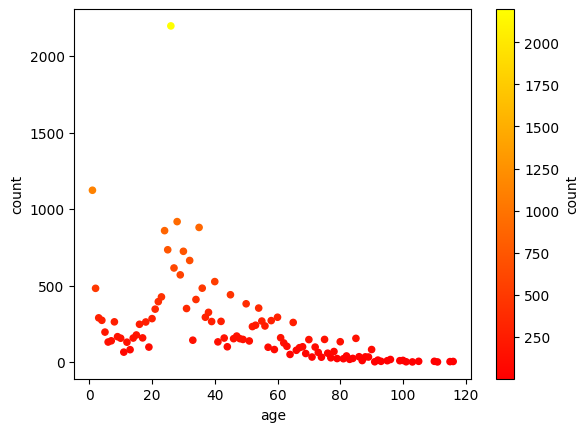

In [ ]:
data['age'].value_counts().reset_index().plot(x='age',y='count' ,kind='scatter',c='count',colormap='autumn')# plotting age to know the data distribution

<Axes: xlabel='gender'>

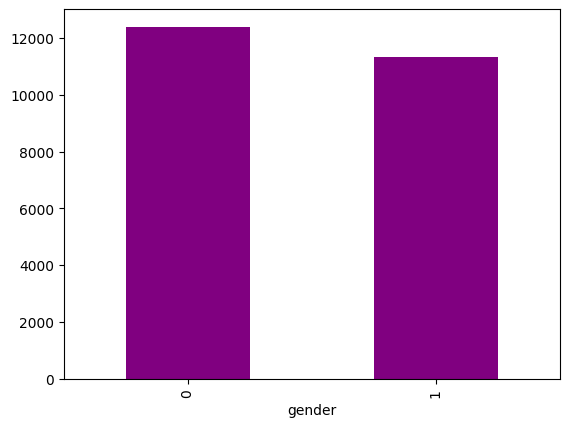

In [ ]:
data['gender'].value_counts().plot(kind='bar',color='purple')# male and female count plot

<Axes: xlabel='ethencity'>

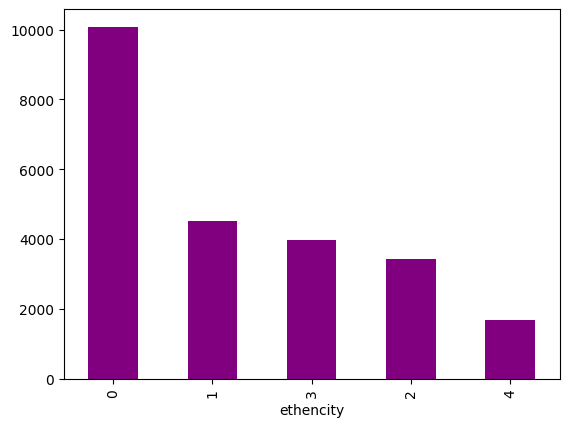

In [ ]:
data['ethencity'].value_counts().plot(kind='bar',color='purple')# ethencity count plot

In [84]:
age_range = [i for i in range(25,35)]
e = 0
filters = data[(data['age'].isin(age_range))&(data['ethencity']==e)]#seperating data for equal distribution
kf = data[~((data['age'].isin(age_range))&(data['ethencity']==e))]
kf.shape,filters.shape

((21491, 4), (2214, 4))

In [85]:
filters = filters.sample(frac=0.5,random_state=42).reset_index(drop=True)#reducing data for equal distribution
df1 = pd.concat([kf,filters],axis=0)#concating original data with sample data
filters1 = df1[(df1['ethencity']==0)]
kf1 = df1[~(df1['ethencity']==0)]
kf1.shape,filters1.shape

((13627, 4), (8971, 4))

In [86]:
filters1 = filters1.sample(frac=0.5,random_state=42).reset_index(drop=True)#reducing data
df2 = pd.concat([kf1,filters1],axis=0)
df2.shape

(18113, 4)

<Axes: xlabel='age', ylabel='count'>

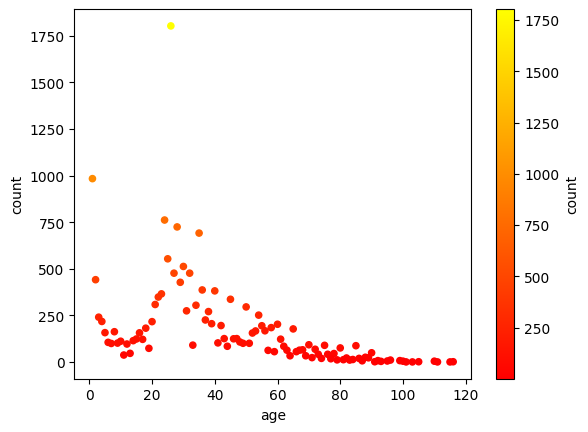

In [87]:
df2['age'].value_counts().reset_index().plot(x='age',y='count' ,kind='scatter',c='count',colormap='autumn')

<Axes: xlabel='gender'>

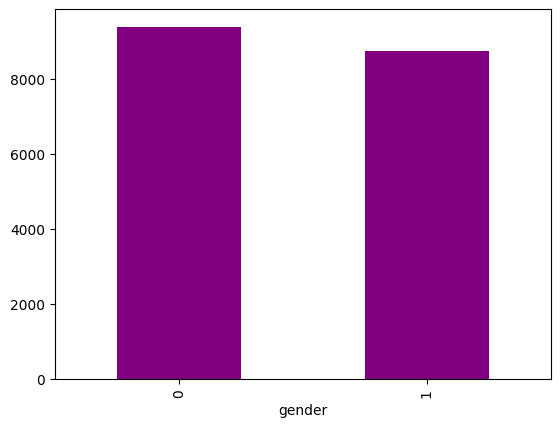

In [88]:
df2['gender'].value_counts().plot(kind='bar',color='purple')

<Axes: xlabel='ethencity'>

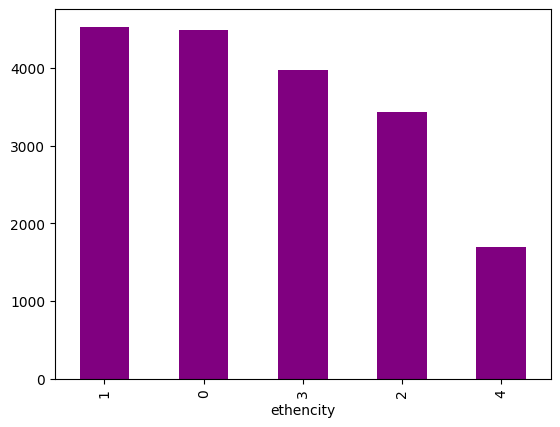

In [89]:
df2['ethencity'].value_counts().plot(kind='bar',color='purple')

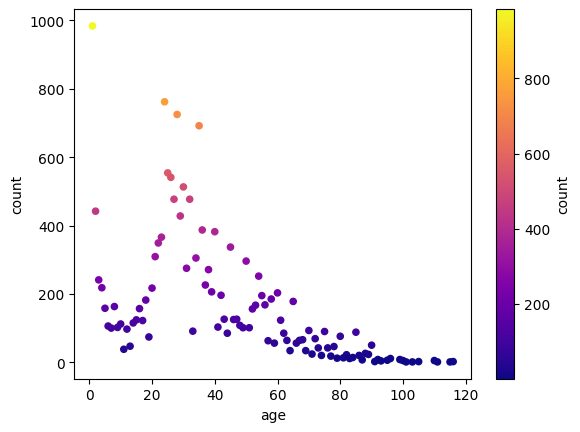

(16851, 4)


In [90]:
age = df2[df2['age']==26]
age = age.sample(frac=0.3,random_state=42)
age.shape
nage = df2[~(df2['age']==26)]
org = pd.concat([nage,age],axis=0)
org['age'].value_counts().reset_index().plot(kind='scatter',x='age',y='count',c='count',colormap='plasma')
plt.show()
print(org.shape)

In [91]:
x = np.concatenate(org['image'].__array__())# extracting images from dataframe
x = x.reshape(-1,110,110,3)

In [ ]:
y = np.array([org['gender'].values,org['age'].values,org['ethencity'].values])
y = y.T
print(y)
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=60,test_size=0.3)# splitting dataset for training and testing
x_train.shape,x_test.shape,y_train.shape,y_test.shape

[[ 0 30  2]
 [ 1 35  3]
 [ 0 43  3]
 ...
 [ 1 26  2]
 [ 1 26  1]
 [ 0 26  2]]


((11795, 110, 110, 3), (5056, 110, 110, 3), (11795, 3), (5056, 3))

In [93]:
y_train = [y_train[:,0],y_train[:,1],y_train[:,2]]
y_test = [y_test[:,0],y_test[:,1],y_test[:,2]]
y_train

[array([1, 0, 1, ..., 0, 0, 0]),
 array([29,  1, 27, ..., 25, 28, 23]),
 array([0, 3, 3, ..., 4, 3, 1])]

In [ ]:
def build(input_shape):
    input = tfk.Input(input_shape)# getting input shape
    con = Conv2D(19,(3,3),activation='relu')(input)# creating cnn layer with 15 filters
    pool = MaxPool2D((2,2),padding='same')(con)
    batch = BatchNormalization()(pool)
    drop = Dropout(0.2)(batch)
    
    con = Conv2D(27,(3,3),activation='relu')(drop)# 27 filters
    pool = MaxPool2D((2,2),padding='valid')(con)
    batch = BatchNormalization()(pool)
    drop = Dropout(0.2)(batch)
    
    con = Conv2D(55,(3,3),activation='relu')(drop)# 55 filters
    pool = MaxPool2D((3,3),padding='same')(con)
    batch = BatchNormalization()(pool)
    drop = Dropout(0.3)(batch)
    
    flat = Flatten()(drop)
    dense = Dense(1000,activation = 'relu')(flat)# neural network with hidden layers(1000,500,100)
    dense = BatchNormalization()(dense)
    
    dense = Dense(500,activation='relu')(dense)
    dense = BatchNormalization()(dense)
    
    dense = Dense(100,activation='relu')(dense)
    dense = BatchNormalization()(dense)
    out = Dense(1,activation='sigmoid',name='gender')(dense)
    out2 = Dense(1,name='age')(dense)
    out3 = Dense(5,activation='softmax',name='Ethencity')(dense)
    
    model = tfk.Model(inputs=input,outputs=[out,out2,out3])
    model.compile(loss=['binary_crossentropy',"mae","SparseCategoricalCrossentropy"],optimizer="Adam",metrics=["accuracy",'mae','accuracy'])# compiling loss functions
    return model

In [95]:
model = build((110,110,3))
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 110, 110,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 108, 108,  │        420 │ input_layer_2[0]… │
│                     │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 54, 54,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │         60 │ max_pooling2d_6[… │
│ (BatchNormalizatio… │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 54, 54,    │          0 │ batch_normalizat… │
│                     │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 52, 52,    │      3,672 │ dropout_6[0][0]   │
│                     │ 27)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 26, 26,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 27)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 26, 26,    │        108 │ max_pooling2d_7[… │
│ (BatchNormalizatio… │ 27)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 26, 26,    │          0 │ batch_normalizat… │
│                     │ 27)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 24, 24,    │     13,420 │ dropout_7[0][0]   │
│                     │ 55)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 8, 8, 55)  │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 55)  │        220 │ max_pooling2d_8[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 8, 8, 55)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 3520)      │          0 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1000)      │  3,521,000 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000)      │      4,000 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 500)       │    500,500 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 500)       │      2,000 │ dense_7[0][0]     │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 4,096,607 (15.63 MB)

 Trainable params: 4,093,213 (15.61 MB)

 Non-trainable params: 3,394 (13.26 KB)

In [ ]:
modelfile='Gender.keras'
checkp=ModelCheckpoint(modelfile,monitor='val_loss',# checkpoint for monitor for loss for get better model
                       verbose=1,save_best_only=True,
                       save_weights_only=False,
                       mode='auto',
                       save_freq='epoch')
threshold=EarlyStopping(patience=50,monitor='val_loss',
                                           restore_best_weights='True',
                                           start_from_epoch = 10)# Early stopping to avoid overfitting

In [ ]:
history = model.fit(x_train,y_train,
          batch_size=14,
                validation_data=(x_test,y_test),
                epochs=200,
                shuffle = True,
                steps_per_epoch=len(x_train) // 18,
                callbacks=[checkp,threshold])# fitting model for training and testing

model.summary()

Epoch 1/200
652/655 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Ethencity_accuracy: 0.4434 - age_mae: 26.3742 - gender_accuracy: 0.7114 - loss: 28.4019
Epoch 1: val_loss improved from inf to 14.92257, saving model to Gender.keras
655/655 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - Ethencity_accuracy: 0.4437 - age_mae: 26.3299 - gender_accuracy: 0.7116 - loss: 28.3563 - val_Ethencity_accuracy: 0.5390 - val_age_mae: 13.2564 - val_gender_accuracy: 0.8167 - val_loss: 14.9226
Epoch 2/200
188/655 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - Ethencity_accuracy: 0.5717 - age_mae: 10.3611 - gender_accuracy: 0.7662 - loss: 11.9743

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 14.92257 to 10.68869, saving model to Gender.keras
655/655 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - Ethencity_accuracy: 0.5690 - age_mae: 10.0823 - gender_accuracy: 0.7718 - loss: 11.6928 - val_Ethencity_accuracy: 0.6143 - val_age_mae: 9.2439 - val_gender_accuracy: 0.8032 - val_loss: 10.6887
Epoch 3/200
647/655 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Ethencity_accuracy: 0.5913 - age_mae: 9.7070 - gender_accuracy: 0.7777 - loss: 11.2544
Epoch 3: val_loss improved from 10.68869 to 10.02451, saving model to Gender.keras
655/655 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - Ethencity_accuracy: 0.5915 - age_mae: 9.7031 - gender_accuracy: 0.7778 - loss: 11.2496 - val_Ethencity_accuracy: 0.5848 - val_age_mae: 8.5441 - val_gender_accuracy: 0.8345 - val_loss: 10.0245
Epoch 4/200
186/655 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - Ethencity_accuracy: 0.6280 - age_mae: 8.8146 - gender_accuracy: 0.7936 - loss: 10.2398
Epoch 4: val_loss did not improve from 10.02451
655/655 ━━━━━━━━━━━━━━━━━━━━

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 110, 110,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 108, 108,  │        420 │ input_layer_2[0]… │
│                     │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 54, 54,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │         60 │ max_pooling2d_6[… │
│ (BatchNormalizatio… │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 54, 54,    │          0 │ batch_normalizat… │
│                     │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 52, 52,    │      3,672 │ dropout_6[0][0]   │
│                     │ 27)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 26, 26,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 27)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 26, 26,    │        108 │ max_pooling2d_7[… │
│ (BatchNormalizatio… │ 27)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 26, 26,    │          0 │ batch_normalizat… │
│                     │ 27)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 24, 24,    │     13,420 │ dropout_7[0][0]   │
│                     │ 55)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 8, 8, 55)  │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 55)  │        220 │ max_pooling2d_8[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 8, 8, 55)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 3520)      │          0 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1000)      │  3,521,000 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000)      │      4,000 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 500)       │    500,500 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 500)       │      2,000 │ dense_7[0][0]     │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 12,283,035 (46.86 MB)

 Trainable params: 4,093,213 (15.61 MB)

 Non-trainable params: 3,394 (13.26 KB)

 Optimizer params: 8,186,428 (31.23 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
24 27
1 1


/tmp/ipykernel_30/3471480312.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f'actual:{y_test[0][i]},predicted:{int(predicted[0][0]>0.5)}')


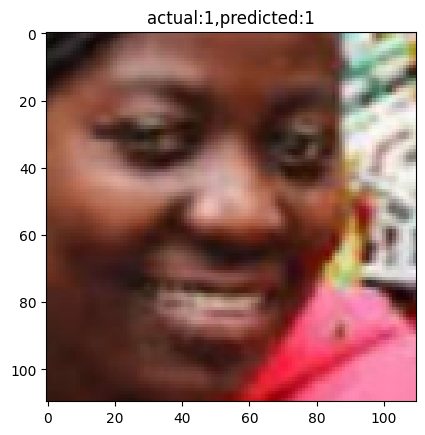

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1 -2
2 2


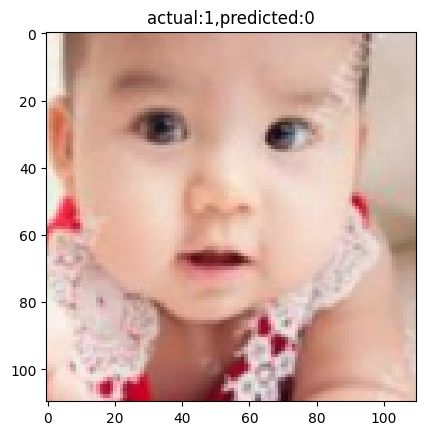

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
32 35
1 1


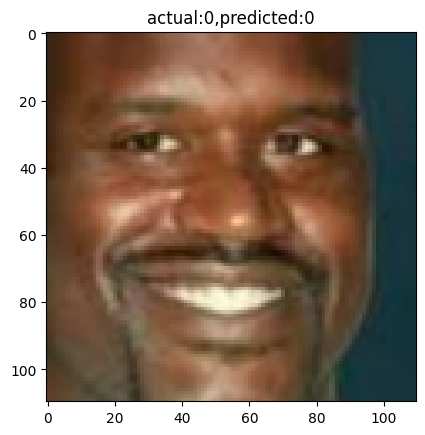

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
70 56
0 0


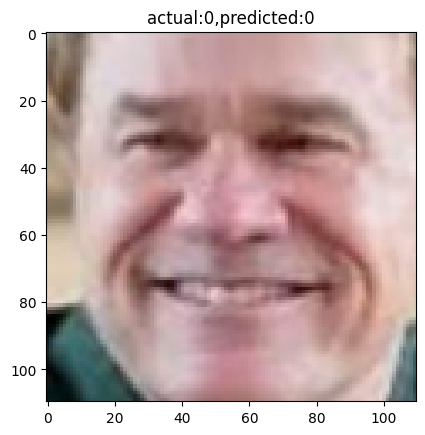

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
28 37
3 3


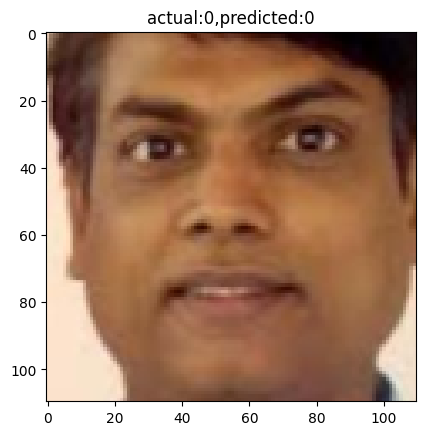

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
29 27
1 1


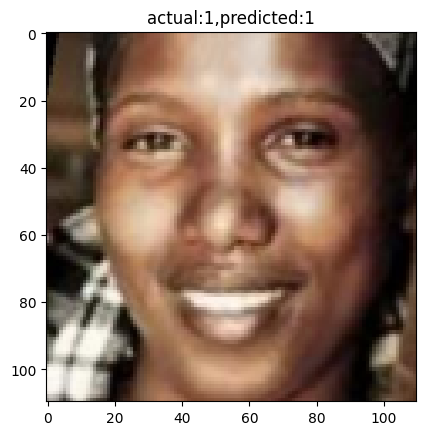

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
42 50
1 1


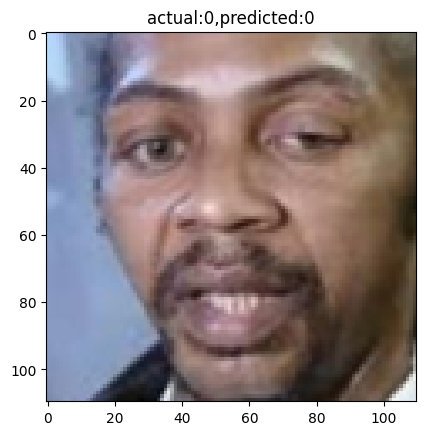

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
28 57
1 1


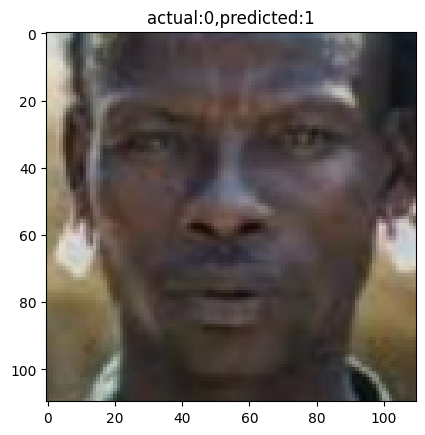

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
29 28
0 0


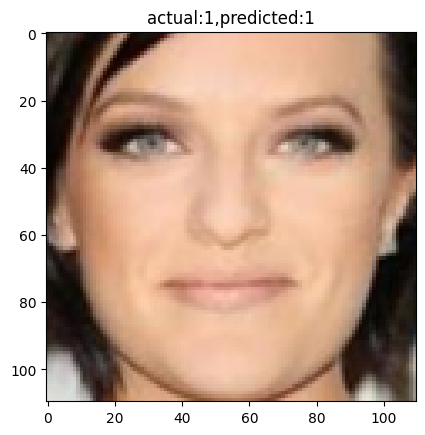

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
33 34
4 0


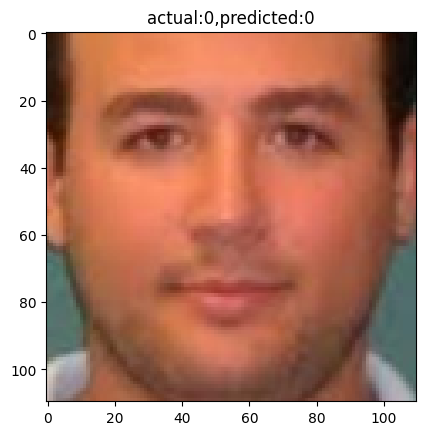

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1 3
3 4


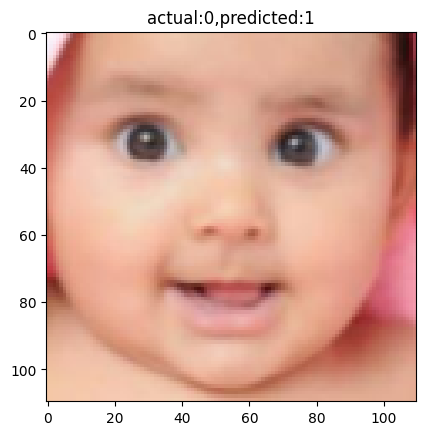

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
17 19
0 0


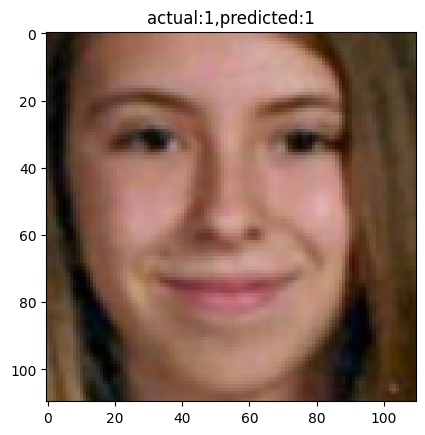

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
30 28
0 0


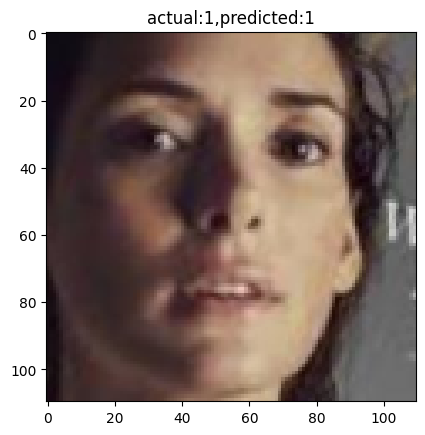

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
30 29
1 1


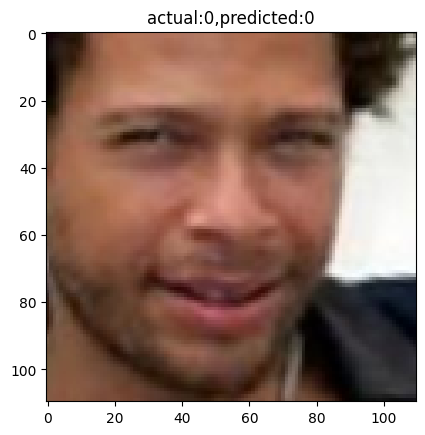

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
9 5
2 2


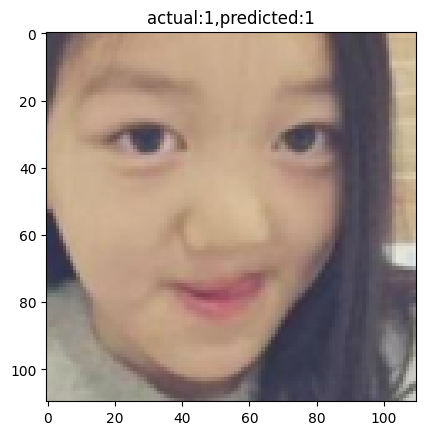

In [98]:
for i in range(15):
    plt.imshow(x_test[i])
    test = np.expand_dims(x_test[i],axis=0)
    predicted =  model.predict(test)
    plt.title(f'actual:{y_test[0][i]},predicted:{int(predicted[0][0]>0.5)}')
    print(y_test[1][i],round(predicted[1][0][0]))
    print(y_test[2][i],np.argmax(predicted[2]))
    plt.show()

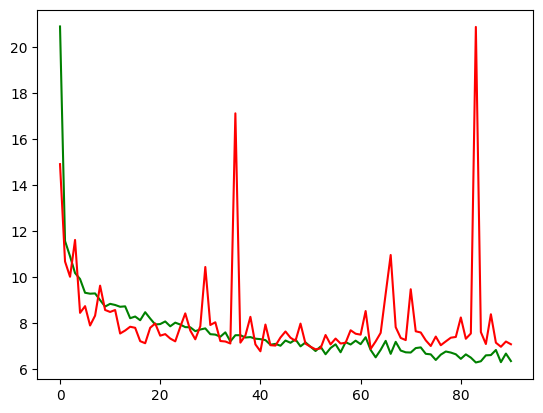

In [99]:
history1 = history.history
loss = history1['loss']
val_loss = history1['val_loss']
plt.plot(loss,c='green')
plt.plot(val_loss,c='red')
plt.show()

In [100]:
y_pred = model.predict(x_test)
y_pred1 = y_pred[0]
ypred_2 = y_pred[1]
ypred3 =  [np.argmax(i) for i in y_pred[2]]

158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [101]:
print('confusion matrix: ',confusion_matrix(y_test[0],y_pred1>0.5))
print('accuracy: ', accuracy_score(y_test[0],y_pred1>0.5))

confusion matrix:  [[2478  265]
 [ 262 2051]]
accuracy:  0.8957674050632911


In [102]:
print('mse: ',mean_squared_error(y_test[1],np.round(ypred_2)))
print('mae: ' ,mean_absolute_error(y_test[1],np.round(ypred_2)))

mse:  68.82911392405063
mae:  5.878560126582278


In [103]:
print('confusion matrix: ',confusion_matrix(y_test[2],ypred3))
print('accuracy: ', accuracy_score(y_test[2],ypred3))

confusion matrix:  [[1089   36   52   78   44]
 [  57 1088   25   72   16]
 [  72   23  787   30   13]
 [ 115   60   16  865   33]
 [ 162   50   46  108  119]]
accuracy:  0.7808544303797469
